In [4]:
import re
import string
import pickle
import keras
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPool2D, Reshape
from keras.layers import Input, concatenate, Dropout
from keras.layers import Embedding, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras import optimizers
from keras import regularizers
from keras.utils.vis_utils import plot_model
from nltk.corpus import stopwords
from keras.models import load_model



In [44]:
train = pd.read_csv('./Dataset/transl_aug/data_degree_4.tsv', delimiter='\t',encoding='utf-8')
dev = pd.read_csv('./dev_en.tsv', delimiter='\t',encoding='utf-8')

In [45]:
def clean_tweets(tweet):
    tweet = re.sub('@(\\w{1,15})\b', '', tweet)
    tweet = tweet.replace("via ", "")
    tweet = tweet.replace("RT ", "")
    tweet = tweet.lower()
    return tweet
    
def clean_url(tweet):
    tweet = re.sub('http\\S+', '', tweet, flags=re.MULTILINE)   
    return tweet
    
def remove_stop_words(tweet):
    stops = set(stopwords.words("english"))
    stops.update(['.',',','"',"'",'?',':',';','(',')','[',']','{','}'])
    toks = [tok for tok in tweet if not tok in stops and len(tok) >= 3]
    return toks
    
def stemming_tweets(tweet):
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in tweet]
    return stemmed_words

def remove_number(tweet):
    newTweet = re.sub('\\d+', '', tweet)
    return newTweet

def remove_hashtags(tweet):
    result = ''

    for word in tweet.split():
        if word.startswith('#') or word.startswith('@'):
            result += word[1:]
            result += ' '
        else:
            result += word
            result += ' '

    return result

In [46]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/saurabh.ramola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
def preprocessing(tweet, swords = True, url = True, stemming = False, ctweets = True, number = True, hashtag = True):

    if ctweets:
        tweet = clean_tweets(tweet)

    if url:
        tweet = clean_url(tweet)

    if hashtag:
        tweet = remove_hashtags(tweet)
    
    twtk = TweetTokenizer(strip_handles=True, reduce_len=True)

    if number:
        tweet = remove_number(tweet)
    
    tokens = [w.lower() for w in twtk.tokenize(tweet) if w != "" and w is not None]

    if swords:
        tokens = remove_stop_words(tokens)

    if stemming:
        tokens = stemming_tweets(tokens)

    text = " ".join(tokens)
#     print(text)
    return text

In [48]:
train_text  = train['text'].map(lambda x: preprocessing(x, swords = True, url = True, stemming = False, ctweets = True, number = False, hashtag = False))
y_train  = train['HS']
id_train = train['id']
ag_train = train['TR']
test_text  = dev['text'].map(lambda x: preprocessing(x, swords = True, url = True, stemming = False, ctweets = True, number = False, hashtag = False))
y_test  = dev['HS']
id_test = dev['id']
ag_test = dev['TR']

data = np.concatenate((train_text, test_text), axis=0)
classes = np.concatenate((y_train, y_test), axis=0)


In [49]:
texts = []
classes = []
for index,word in enumerate(train_text):
    if y_train[index]:
        texts.append(word)
        if ag_train[index]:
            classes.append(0)
        else:
            classes.append(1)

train_text = texts
y_train = classes

texts = []
classes = []
for index,word in enumerate(test_text):
    if y_test[index]:
        texts.append(word)
        if ag_test[index]:
            classes.append(0)
        else:
            classes.append(1)

test_text = texts
y_test = classes

In [50]:
len(train_text),len(test_text)

(15132, 427)

In [51]:
from keras.utils import np_utils
count1 = 0
count2 = 0
for x in y_train:
    if x==0:
        count1+=1
    else:
        count2+=1


In [52]:
count1,count2

(5364, 9768)

In [162]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [53]:
def word_embeddings(word_index, num_words, word_embedding_dim):
    embeddings_index = {}
    
    f = open('./glove.6B.300d.txt', 'r', encoding='utf-8')
    
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    
    f.close()

    matrix = np.zeros((num_words, word_embedding_dim))
    
    for word, i in word_index.items():
        if i >= max_features:
            continue
        
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            matrix[i] = embedding_vector

    return matrix

In [54]:
embedding_dim = 300
max_features = 20000
maxlen = 40
batch_size = 64
epochs = 5
filter_sizes = [2,3]
num_filters = 512
drop = 0.5

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_text)

X = tokenizer.texts_to_sequences(train_text)
Y = tokenizer.texts_to_sequences(test_text)

tweets = sequence.pad_sequences(X, maxlen=maxlen)
x_test = sequence.pad_sequences(Y, maxlen=maxlen)

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index) + 1)

In [55]:
x_train, x_val, y_train, y_val = train_test_split(tweets, y_train, test_size=0.1, random_state=None)


In [56]:
from tqdm import tqdm
embedding_matrix = word_embeddings(word_index, num_words, embedding_dim)

400000it [00:35, 11158.51it/s]


In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [57]:
tweet_input = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True)(tweet_input)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

cnn1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='tanh')(reshape)

max1 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(cnn1)

cnn2 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='tanh')(reshape)

max2 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(cnn2)


concatenated_tensor = Concatenate(axis=1)([max1, max2])

flatten = Flatten()(concatenated_tensor)

dropout = Dropout(drop)(flatten)

dens = Dense(num_filters, activation='relu')(dropout)

output = Dense(1, activation='sigmoid')(dens)

model = Model(inputs=tweet_input, outputs=output)

opt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 300)      4007100     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 40, 300, 1)   0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 39, 1, 512)   307712      reshape_3[0][0]                  
__________________________________________________________________________________________________
conv2d_6 (

In [58]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=4, verbose=1)
mcp_save = ModelCheckpoint('./tr_mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')
callbacks_list = [mcp_save]
model.fit(x_train, y_train, batch_size=batch_size, epochs=20, shuffle=True, callbacks = callbacks_list,validation_data=(x_val, y_val))



Train on 13618 samples, validate on 1514 samples
Epoch 1/20
13618/13618 [==============================] - 23s 2ms/step - loss: 0.4505 - acc: 0.8199 - val_loss: 0.2956 - val_acc: 0.8692
Epoch 2/20
13618/13618 [==============================] - 23s 2ms/step - loss: 0.2589 - acc: 0.8935 - val_loss: 0.2428 - val_acc: 0.8983
Epoch 3/20
13618/13618 [==============================] - 23s 2ms/step - loss: 0.1870 - acc: 0.9255 - val_loss: 0.2280 - val_acc: 0.9122
Epoch 4/20
13618/13618 [==============================] - 23s 2ms/step - loss: 0.1411 - acc: 0.9449 - val_loss: 0.2170 - val_acc: 0.9115
Epoch 5/20
13618/13618 [==============================] - 23s 2ms/step - loss: 0.1119 - acc: 0.9590 - val_loss: 0.1954 - val_acc: 0.9260
Epoch 6/20
13618/13618 [==============================] - 23s 2ms/step - loss: 0.0913 - acc: 0.9668 - val_loss: 0.1868 - val_acc: 0.9287
Epoch 7/20
13618/13618 [==============================] - 23s 2ms/step - loss: 0.0777 - acc: 0.9719 - val_loss: 0.1868 - val_acc:

In [59]:
a = (model.predict(x_test, batch_size=batch_size) > 0.5).astype(int)

In [60]:
y_pred = a

In [61]:
y_pred[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

In [62]:
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

print("F1.........: %f" %(f1_score(y_test, y_pred, average="macro")))
print("Precision..: %f" %(precision_score(y_test, y_pred, average="macro")))
print("Recall.....: %f" %(recall_score(y_test, y_pred, average="macro")))
print("Accuracy...: %f" %(accuracy_score(y_test, y_pred)))

F1.........: 0.908665
Precision..: 0.909269
Recall.....: 0.909269
Accuracy...: 0.908665


[[197  22]
 [ 12 196]]


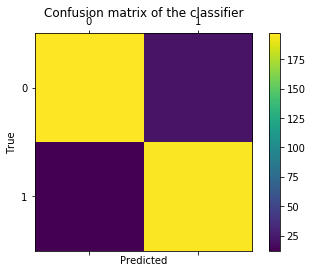

In [216]:
import sklearn.metrics as metrics
import pylab as pl
import matplotlib.pyplot as plt
labels = [0, 1]
cm = metrics.confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
print(metrics.classification_report(y_test, y_pred, digits=3))
val1 = 0.5
val2 = 0.8

              precision    recall  f1-score   support

           0      0.658     0.510     0.575       204
           1      0.628     0.758     0.687       223

    accuracy                          0.639       427
   macro avg      0.643     0.634     0.631       427
weighted avg      0.643     0.639     0.633       427



In [29]:
x1 = preprocessing("I am going to punch the president")
x1 = [x1]
y1 = tokenizer.texts_to_sequences(x1)
tweets1 = sequence.pad_sequences(y1, maxlen=maxlen)
print(hash_map[((model.predict(tweets1) > 0.5).astype(int))[0][0]])

NameError: name 'hash_map' is not defined

In [26]:
x1 = preprocessing("i am going to build a wall for the immigrants and kill them")
x1 = [x1]
y1 = tokenizer.texts_to_sequences(x1)
tweets1 = sequence.pad_sequences(y1, maxlen=maxlen)
print(hash_map[((model.predict(tweets1) > 0.5).astype(int))[0][0]])

targeted


In [30]:
model1 = load_model('.mdl_wts.hdf5')

TypeError: ('Keyword argument not understood:', 'data_format')

In [28]:
model1.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])


In [29]:
x1 = preprocessing("i am going to build a wall for mexicans and kill them")
x1 = [x1]
y1 = tokenizer.texts_to_sequences(x1)
tweets1 = sequence.pad_sequences(y1, maxlen=maxlen)
if (model1.predict(tweets1) > 0.5).astype(int):
    temp = (model.predict(tweets1) > 0.5).astype(int)
    print(hash_map[temp[0][0]])

targeted


In [24]:
hash_map = {0:'individual',1:'targeted'}

In [221]:
hash_map[0]

'individual'

In [152]:
x1 = preprocessing("i am going to kill you")
x1 = [x1]
y1 = tokenizer.texts_to_sequences(x1)
tweets1 = sequence.pad_sequences(y1, maxlen=maxlen)
if (model1.predict(tweets1) > val1).astype(int):
    temp = (model.predict(tweets1) > val2).astype(int)
    print(hash_map[temp[0][0]])

individual
